# Time Series Segmentation
In this notebook, we evaluate the WSS algorithms

In [1]:
import numpy as np
import pandas as pd
import daproli as dp

from scipy.stats import wilcoxon

import pandas as pd
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
import seaborn as sns
from aeon.visualisation import plot_critical_difference

sns.set_theme()
sns.set_color_codes()

import sys
sys.path.append("../")

from tqdm import tqdm


In [2]:
print("hello")

hello


In [3]:
df = pd.read_csv('../experiments/results/ad_results-.csv')



In [4]:
#df

In [5]:
# Reshape the DataFrame
df_ad = df.pivot(index='dataset', columns='method', values='top_ad').reset_index()
#df_ad

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   dataset       58 non-null     object 
 1   ACF           58 non-null     float64
 2   Autoperiod    58 non-null     float64
 3   FFT           58 non-null     float64
 4   MWF           58 non-null     float64
 5   ReWin         58 non-null     float64
 6   RobustPeriod  58 non-null     float64
 7   SuSS          58 non-null     float64
dtypes: float64(7), object(1)
memory usage: 3.8+ KB


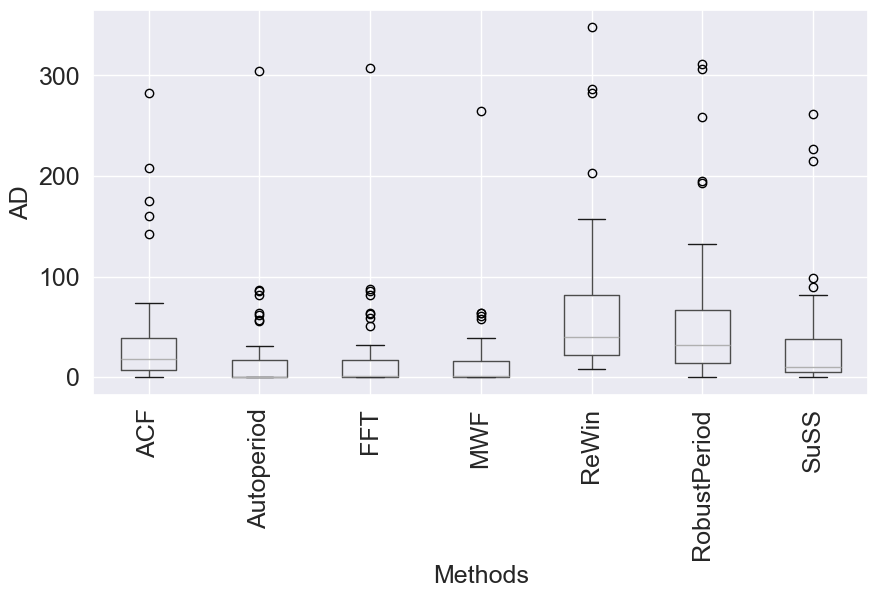

In [6]:
df_ad.info()
fontsize = 18
# Create the plot
_, ax = plt.subplots(figsize=(10, 5))
df_ad.boxplot(ax=ax, rot=90)

# Set labels and their font sizes
ax.set_ylabel("AD", fontsize=fontsize)
ax.set_xlabel("Methods", fontsize=fontsize)

# Adjust tick label font sizes using tick_params
ax.tick_params(axis='x', labelsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)

#plt.yscale("log")
#plt.savefig("Boxplot.pdf",  bbox_inches='tight')


# Show the plot
plt.show()



Let's calculate the mean/median/std score.

In [7]:
df_ad.iloc[:,1:].mean(axis=0).sort_values(ascending=True).round(3)

method
MWF             15.114
Autoperiod      17.148
FFT             17.733
SuSS            32.294
ACF             36.555
RobustPeriod    57.389
ReWin           68.632
dtype: float64

In [8]:
df_ad.iloc[:,1:].median(axis=0).sort_values(ascending=True).round(3)

method
Autoperiod       0.007
FFT              1.000
MWF              1.001
SuSS            10.000
ACF             18.001
RobustPeriod    31.917
ReWin           39.500
dtype: float64

In [9]:
df_ad.iloc[:,1:].std(axis=0).sort_values().round(3)

method
MWF             37.557
Autoperiod      45.067
FFT             45.232
ACF             54.162
SuSS            54.258
RobustPeriod    70.967
ReWin           71.011
dtype: float64

Let's compute the wins per method.

In [10]:
ranks = df_ad.iloc[:,1:].rank(1, method='min', ascending=True)
means = np.array(ranks.mean(axis=0))
args = np.argsort(means)

In [11]:
for mean, name in zip(means[args], df_ad.columns[1:].to_numpy()[args]):
    print(f"{name}:wins={ranks[ranks[name] == 1].shape[0]} rank={np.round(mean, 1)}")

Autoperiod:wins=41 rank=1.7
MWF:wins=27 rank=2.2
FFT:wins=23 rank=2.5
ACF:wins=10 rank=3.7
SuSS:wins=11 rank=3.8
RobustPeriod:wins=6 rank=4.9
ReWin:wins=0 rank=6.8


In [12]:
# Count how many methods have rank 1 in each row
ties_per_row = (ranks == 1).sum(axis=1)

# Count how many times there are ties
num_ties = (ties_per_row > 1).sum()

print(f"Number of rows with ties: {num_ties}")

Number of rows with ties: 35


Let's plot the CD diagram.

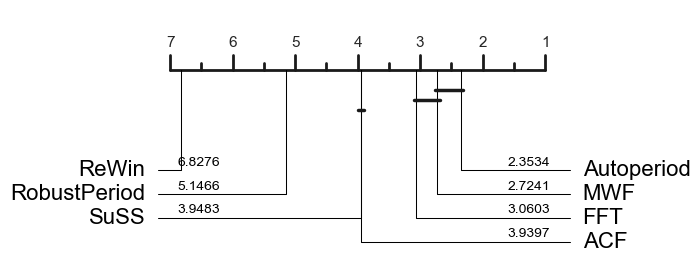

In [13]:
fig,ax, p_values = plot_critical_difference(
    scores=df_ad.iloc[:, 1:].to_numpy(),
    labels=df_ad.columns[1:].to_numpy(),
    correction="holm",
    alpha=0.05,
    lower_better = True,
    return_p_values=True
)


#plt.yscale("log")
#plt.savefig("CDD.pdf",  bbox_inches='tight')



# Show the plot
plt.show()


#plt.savefig("../figures/cd_segmentation_comparative.pdf", bbox_inches="tight")

In [14]:
p_values

array([[1.00000000e+00, 2.41490241e-01, 5.81439057e-03, 8.64502438e-05,
        1.81053433e-04, 1.85562012e-08, 1.74567874e-11],
       [0.00000000e+00, 1.00000000e+00, 2.24764927e-01, 5.55278156e-05,
        9.16753571e-05, 9.92131636e-09, 1.74773301e-11],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 3.04785318e-04,
        1.05576968e-03, 5.33568351e-08, 1.74391969e-11],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
        9.80585312e-01, 2.07064283e-05, 2.45243265e-11],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.00000000e+00, 2.36468689e-06, 3.61760898e-11],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.00000000e+00, 3.98127316e-07],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [15]:
print(df_ad.columns[1:].to_numpy())

['ACF' 'Autoperiod' 'FFT' 'MWF' 'ReWin' 'RobustPeriod' 'SuSS']


Let's compute wins/losses against MWF.

In [16]:
for rival in df_ad.columns[1:]:
    if rival == "Autoperiod": continue

    df_pair = df_ad[["Autoperiod", rival]]
    pair_ranks = df_pair.rank(1, method = 'min', ascending=True)

    wins = pair_ranks[(pair_ranks["Autoperiod"] == 1) & (pair_ranks[rival] == 2)].shape[0]
    losses = pair_ranks[(pair_ranks["Autoperiod"] == 2) & (pair_ranks[rival] == 1)].shape[0]
    ties = pair_ranks[(pair_ranks["Autoperiod"] == 1) & (pair_ranks[rival] == 1)].shape[0]

    assert wins + losses + ties == pair_ranks.shape[0]

    print(f"Autoperiod vs {rival}: (wins/losses/ties): {wins}/{losses}/{ties}")

Autoperiod vs ACF: (wins/losses/ties): 40/9/9
Autoperiod vs FFT: (wins/losses/ties): 25/6/27
Autoperiod vs MWF: (wins/losses/ties): 22/10/26
Autoperiod vs ReWin: (wins/losses/ties): 58/0/0
Autoperiod vs RobustPeriod: (wins/losses/ties): 47/4/7
Autoperiod vs SuSS: (wins/losses/ties): 40/12/6


In [17]:
# Initialize results DataFrame
wilcoxon_results = []

# Iterate through each rival method
for rival in df_ad.columns[1:]:
    if rival == "MWF":
        continue  # Skip self-comparison

    # Get RMSE values for MWF and the rival method
    mwf_rmse = df_ad["MWF"]
    rival_rmse = df_ad[rival]

    # Perform Wilcoxon Signed-Rank Test
    stat, p_value = wilcoxon(mwf_rmse, rival_rmse, alternative='less')

    # Store results in a list
    wilcoxon_results.append([rival, stat, p_value])

# Convert to DataFrame
df_wilcoxon = pd.DataFrame(wilcoxon_results, columns=["Rival", "Wilcoxon_Statistic", "p_value"])

# Sort by p-value (optional)
df_wilcoxon = df_wilcoxon.sort_values(by="p_value", ascending=True)

print(df_wilcoxon)

          Rival  Wilcoxon_Statistic       p_value
3         ReWin                 0.0  1.747733e-11
4  RobustPeriod                81.5  9.921316e-09
0           ACF               224.0  5.552782e-05
5          SuSS               293.0  9.167536e-05
2           FFT               301.5  2.247649e-01
1    Autoperiod               301.5  7.585098e-01


In [18]:
# Initialize results DataFrame
wilcoxon_results = []

# Iterate through each rival method
for rival in df_ad.columns[1:]:
    if rival == "ACF":
        continue  # Skip self-comparison

    # Get RMSE values for MWF and the rival method
    mwf_rmse = df_ad["ACF"]
    rival_rmse = df_ad[rival]

    # Perform Wilcoxon Signed-Rank Test
    stat, p_value = wilcoxon(mwf_rmse, rival_rmse, alternative='less')

    # Store results in a list
    wilcoxon_results.append([rival, stat, p_value])

# Convert to DataFrame
df_wilcoxon = pd.DataFrame(wilcoxon_results, columns=["Rival", "Wilcoxon_Statistic", "p_value"])

# Sort by p-value (optional)
df_wilcoxon = df_wilcoxon.sort_values(by="p_value", ascending=True)

print(df_wilcoxon)

          Rival  Wilcoxon_Statistic       p_value
3         ReWin                 6.5  2.452433e-11
4  RobustPeriod               252.5  2.070643e-05
5          SuSS              1086.5  9.805853e-01
1           FFT              1028.5  9.996952e-01
0    Autoperiod               990.0  9.999135e-01
2           MWF              1001.0  9.999445e-01


In [19]:
# Initialize results DataFrame
wilcoxon_results = []

# Iterate through each rival method
for rival in df_ad.columns[1:]:
    if rival == "RobustPeriod":
        continue  # Skip self-comparison

    # Get RMSE values for MWF and the rival method
    mwf_rmse = df_ad["RobustPeriod"]
    rival_rmse = df_ad[rival]

    # Perform Wilcoxon Signed-Rank Test
    stat, p_value = wilcoxon(mwf_rmse, rival_rmse, alternative='less')

    # Store results in a list
    wilcoxon_results.append([rival, stat, p_value])

# Convert to DataFrame
df_wilcoxon = pd.DataFrame(wilcoxon_results, columns=["Rival", "Wilcoxon_Statistic", "p_value"])

# Sort by p-value (optional)
df_wilcoxon = df_wilcoxon.sort_values(by="p_value", ascending=True)

print(df_wilcoxon)

        Rival  Wilcoxon_Statistic       p_value
4       ReWin               218.0  3.981273e-07
0         ACF              1178.5  9.999793e-01
5        SuSS              1359.0  9.999976e-01
2         FFT              1188.0  9.999999e-01
1  Autoperiod              1250.0  1.000000e+00
3         MWF              1349.5  1.000000e+00


In [20]:
# Initialize results DataFrame
wilcoxon_results = []

# Iterate through each rival method
for rival in df_ad.columns[1:]:
    if rival == "Autoperiod":
        continue  # Skip self-comparison

    # Get RMSE values for MWF and the rival method
    mwf_rmse = df_ad["Autoperiod"]
    rival_rmse = df_ad[rival]

    # Perform Wilcoxon Signed-Rank Test
    stat, p_value = wilcoxon(mwf_rmse, rival_rmse, alternative='less')

    # Store results in a list
    wilcoxon_results.append([rival, stat, p_value])

# Convert to DataFrame
df_wilcoxon = pd.DataFrame(wilcoxon_results, columns=["Rival", "Wilcoxon_Statistic", "p_value"])

# Sort by p-value (optional)
df_wilcoxon = df_wilcoxon.sort_values(by="p_value", ascending=True)

print(df_wilcoxon)

          Rival  Wilcoxon_Statistic       p_value
3         ReWin                 0.0  1.745679e-11
4  RobustPeriod                76.0  1.855620e-08
0           ACF               235.0  8.645024e-05
5          SuSS               297.5  1.810534e-04
1           FFT               121.0  5.814391e-03
2           MWF               226.5  2.414902e-01


In [21]:
# Initialize results DataFrame
wilcoxon_results = []

# Iterate through each rival method
for rival in df_ad.columns[1:]:
    if rival == "FFT":
        continue  # Skip self-comparison

    # Get RMSE values for MWF and the rival method
    mwf_rmse = df_ad["FFT"]
    rival_rmse = df_ad[rival]

    # Perform Wilcoxon Signed-Rank Test
    stat, p_value = wilcoxon(mwf_rmse, rival_rmse, alternative='less')

    # Store results in a list
    wilcoxon_results.append([rival, stat, p_value])

# Convert to DataFrame
df_wilcoxon = pd.DataFrame(wilcoxon_results, columns=["Rival", "Wilcoxon_Statistic", "p_value"])

# Sort by p-value (optional)
df_wilcoxon = df_wilcoxon.sort_values(by="p_value", ascending=True)

print(df_wilcoxon)

          Rival  Wilcoxon_Statistic       p_value
3         ReWin                 0.0  1.743920e-11
4  RobustPeriod                87.0  5.335684e-08
0           ACF               297.5  3.047853e-04
5          SuSS               351.5  1.055770e-03
2           MWF               401.5  7.752351e-01
1    Autoperiod               375.0  9.941856e-01


In [22]:
# Initialize results DataFrame
wilcoxon_results = []

# Iterate through each rival method
for rival in df_ad.columns[1:]:
    if rival == "SuSS":
        continue  # Skip self-comparison

    # Get RMSE values for MWF and the rival method
    mwf_rmse = df_ad["SuSS"]
    rival_rmse = df_ad[rival]

    # Perform Wilcoxon Signed-Rank Test
    stat, p_value = wilcoxon(mwf_rmse, rival_rmse, alternative='less')

    # Store results in a list
    wilcoxon_results.append([rival, stat, p_value])

# Convert to DataFrame
df_wilcoxon = pd.DataFrame(wilcoxon_results, columns=["Rival", "Wilcoxon_Statistic", "p_value"])

# Sort by p-value (optional)
df_wilcoxon = df_wilcoxon.sort_values(by="p_value", ascending=True)

print(df_wilcoxon)

          Rival  Wilcoxon_Statistic       p_value
4         ReWin                14.0  3.617609e-11
5  RobustPeriod               237.0  2.364687e-06
0           ACF               566.5  1.941469e-02
2           FFT              1026.5  9.989442e-01
1    Autoperiod              1080.5  9.998189e-01
3           MWF              1138.0  9.999083e-01


In [23]:
mwf_rmse = df_ad["Autoperiod"]
rival_rmse = df_ad["MWF"]
stat, p_value = wilcoxon(mwf_rmse, rival_rmse, alternative='less')
print(p_value)

0.24149024062362834


In [24]:
from scipy.stats import wilcoxon

# Beispiel für zwei Spalten aus df_ad
stat, p_manual = wilcoxon(df_ad.iloc[:, 2], df_ad.iloc[:, 5], alternative="less")
print(f"Manuell berechneter p-Wert: {p_manual}")
print(f"p-Wert aus plot_critical_difference: {p_values[2,5]}")

Manuell berechneter p-Wert: 1.74567874294591e-11
p-Wert aus plot_critical_difference: 5.335683512016532e-08


In [26]:
p_val

0.9999083246429277

Examples of the results

In [27]:
# Ensure dataset is numeric by dropping non-numeric columns
df_numeric = df_ad.drop(columns=["method", "dataset"], errors="ignore").apply(pd.to_numeric, errors='coerce')

# Rank RMSE values row-wise
ranked_df = df_numeric.rank(axis=1, method="min", ascending=True)

# Define the target ranking order
target_ranking = {
     "Autoperiod": 1,
    "MWF": 2,
    "FFT": 3,
    "SuSS": 4,
    "ACF": 5,
    "RobustPeriod": 6
}


# Find a row where ranks match the target order
for index, row in ranked_df.iterrows():
    if all(row[method] == target_ranking[method] for method in target_ranking):
        print("Found matching example at index:", index)
        print(df_ad.iloc[index])  # Print the full row (including dataset name)
        break
else:
    print("No exact match found in the dataset.")


No exact match found in the dataset.


In [28]:
ranked_df

method,ACF,Autoperiod,FFT,MWF,ReWin,RobustPeriod,SuSS
0,5.0,1.0,1.0,1.0,7.0,6.0,1.0
1,4.0,1.0,5.0,1.0,7.0,5.0,1.0
2,4.0,3.0,5.0,1.0,7.0,6.0,2.0
3,1.0,4.0,6.0,2.0,7.0,5.0,3.0
4,4.0,1.0,1.0,5.0,6.0,7.0,3.0
5,2.0,2.0,2.0,2.0,7.0,2.0,1.0
6,5.0,1.0,1.0,6.0,7.0,1.0,1.0
7,7.0,2.0,1.0,3.0,6.0,5.0,4.0
8,4.0,1.0,2.0,5.0,7.0,6.0,3.0
9,1.0,1.0,4.0,1.0,6.0,5.0,7.0


In [29]:
# Ensure RMSE values are numeric
df_numeric = df_ad.drop(columns=["method", "dataset"], errors="ignore").apply(pd.to_numeric, errors='coerce')

# Rank RMSE values row-wise (1 = lowest RMSE)
ranked_df = df_numeric.rank(axis=1, method="min", ascending=True)

# Define the target ranking order
target_ranking = {
     "Autoperiod": 1,
    "MWF": 2,
    "FFT": 3,
    "SuSS": 4,
    "ACF": 5,
    "RobustPeriod": 6
}

# Compute the ranking distance for each row
ranked_df["rank_distance"] = ranked_df.apply(lambda row: sum(abs(row[method] - target_ranking[method]) for method in target_ranking), axis=1)

# Find the row with the smallest rank distance
best_match_index = ranked_df["rank_distance"].idxmin()

# Print results
print("Closest match found at index:", best_match_index)
print("Dataset name:", df_ad.loc[best_match_index, "dataset"])
print("RMSE values for this dataset:")
print(df_ad.iloc[best_match_index])
print("\nRanking distance:", ranked_df.loc[best_match_index, "rank_distance"])

Closest match found at index: 17
Dataset name: EOGVerticalSignal
RMSE values for this dataset:
method
dataset         EOGVerticalSignal
ACF                       39.0005
Autoperiod                 0.0005
FFT                        1.0005
MWF                        0.0005
ReWin                     76.0005
RobustPeriod              58.0005
SuSS                       8.0005
Name: 17, dtype: object

Ranking distance: 1.0


In [30]:
ranked_df.loc[[17]]

method,ACF,Autoperiod,FFT,MWF,ReWin,RobustPeriod,SuSS,rank_distance
17,5.0,1.0,3.0,1.0,7.0,6.0,4.0,1.0


In [31]:
print("Dataset name:", df_ad.loc[17, "dataset"])

Dataset name: EOGVerticalSignal


In [32]:
ranked_df.sort_values(by=['rank_distance'])

method,ACF,Autoperiod,FFT,MWF,ReWin,RobustPeriod,SuSS,rank_distance
57,5.0,1.0,2.0,2.0,7.0,6.0,4.0,1.0
17,5.0,1.0,3.0,1.0,7.0,6.0,4.0,1.0
39,5.0,1.0,2.0,2.0,7.0,6.0,4.0,1.0
40,5.0,1.0,3.0,1.0,7.0,6.0,4.0,1.0
41,5.0,1.0,3.0,1.0,7.0,6.0,4.0,1.0
36,5.0,1.0,3.0,1.0,7.0,6.0,4.0,1.0
52,5.0,1.0,2.0,2.0,7.0,6.0,4.0,1.0
54,5.0,1.0,2.0,2.0,7.0,6.0,4.0,1.0
56,4.0,1.0,3.0,2.0,7.0,6.0,5.0,2.0
16,5.0,1.0,3.0,1.0,7.0,6.0,3.0,2.0
